# MOT Strength
MOT strength was varied from 2.5V to 4V in intervals of .15V at 10 trials apiece.

In [1]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter

#other utils
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [2]:
DATA_DIR = Path("../data/mar09/MOT_current")

#count from .1 to 1.0 in intervals of 1 and then start over
time_list = np.arange(2.5, 4.1, .15)
time_data = list(zip(*product(range(10), time_list)))[1]
data = []

In [5]:
for i,time in enumerate(time_data):
    print(i, time)
    data.append(
        DataRun(16+i, time)
    )

0 2.5


/tmp/ipykernel_360841/2969234111.py:46: RuntimeWarning: invalid value encountered in divide
  I_div_arr = np.divide(I_arr, I0_arr)


1 2.65
2 2.8
3 2.9499999999999997
4 3.0999999999999996
5 3.2499999999999996
6 3.3999999999999995
7 3.5499999999999994
8 3.6999999999999993
9 3.849999999999999
10 3.999999999999999
11 2.5
12 2.65
13 2.8
14 2.9499999999999997
15 3.0999999999999996
16 3.2499999999999996
17 3.3999999999999995
18 3.5499999999999994
19 3.6999999999999993
20 3.849999999999999
21 3.999999999999999
22 2.5
23 2.65
24 2.8
25 2.9499999999999997
26 3.0999999999999996
27 3.2499999999999996
28 3.3999999999999995
29 3.5499999999999994
30 3.6999999999999993
31 3.849999999999999
32 3.999999999999999
33 2.5
34 2.65
35 2.8
36 2.9499999999999997
37 3.0999999999999996
38 3.2499999999999996
39 3.3999999999999995
40 3.5499999999999994
41 3.6999999999999993
42 3.849999999999999
43 3.999999999999999
44 2.5
45 2.65
46 2.8
47 2.9499999999999997
48 3.0999999999999996
49 3.2499999999999996
50 3.3999999999999995
51 3.5499999999999994
52 3.6999999999999993
53 3.849999999999999
54 3.999999999999999
55 2.5
56 2.65
57 2.8
58 2.949999999

In [6]:
class DataRun:
    def __init__(self, num, time):
        self.num = num
        self.time = time

        self.images()
        self.load()
        #self.mask(.20)
        #extract blob rectangle from image
        self.blob_image = self.od_arr[605-75:605+75, 620-75:620+75]
        #[round(self.cy)-75:round(self.cy)+75, round(self.cx)-75:round(self.cx)+75]
        #apply a median filter
        self.fit()

    def incircle(self, center, radius, pt):
            return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2

    def images(self):
        images =  [imread(DATA_DIR / f"image_{self.num}_{i}.tif") for i in range(4)]

        im0 = images[0]
        im0_background = images[2]
        im1 = images[1]
        im1_background = images[3]

        I0_arr=np.subtract(np.array(im0),
                            np.array(im0_background)).astype(int)
        I_arr=np.subtract(np.array(im1),
                            np.array(im1_background)).astype(int)

        return I_arr, I0_arr

    def grow_box(self,box, factor):
        width = box[3]-box[1]
        height = box[2]-box[0]
        x1 = round(box[1] - width*factor)
        y1 = round(box[0] - height*factor)
        x2 = round(box[3] + width*factor)
        y2 = round(box[2] + height*factor)
        return (x1,y1,x2,y2)

    def load(self):

        I_arr, I0_arr = self.images()

        I_div_arr = np.divide(I_arr, I0_arr)
        od_arr = np.log(I_div_arr)

        #first pass, just clip anything not within the aperture
        for i,row in enumerate(od_arr):
            for j, pixel in enumerate(row):
                if pixel < 0 or not self.incircle((605,620),150,(i,j)):
                    od_arr[i][j] = 0

        self.od_arr = od_arr

    def mask(self, threshhold):
        value_mask = self.od_arr[:,:] > threshhold
        self.mask_filtered = median_filter(value_mask, 50)

        blobs = label(self.mask_filtered)
        props = regionprops(blobs) #generate a properties dictionary

        if not props:
            return 0

        self.cy, self.cx = props[0].centroid

        return props[0].num_pixels

    def gaussian_fit(self, x, A, mu, sigma):
        return A*np.exp(-(x-mu)**2/(2*sigma**2))
    
    def fit(self):
        #compute marginals and fit to a gaussian

        x, y = margins(self.blob_image)
        x = x.T[0]
        y = y[0]

        x[x == np.inf] = 0
        y[y == np.inf] = 0

        self.popt_x, self.pcov_x = curve_fit(self.gaussian_fit, np.arange(len(x)), x, p0 =[350, 150, 60])
        self.popt_y, self.pcov_y = curve_fit(self.gaussian_fit, np.arange(len(y)), y, [350,150,60])

        self.x = x
        self.y = y

    def atom_number(self):
        x = np.linspace(-1000, 1000, 10000)
        return np.trapz(self.gaussian_fit(x, *self.popt_x),x)*np.trapz(self.gaussian_fit(x, *self.popt_y),x)

    def plot_box(self):
        #draw bounding box
        fig, ax = plt.subplots()
        rect = plt.Rectangle((self.box[0], self.box[1]), self.box[2]-self.box[0], self.box[3]-self.box[1])
        rect.set(fill=False, color = "red")
        ax.add_artist(rect)
        ax.imshow(self.od_arr)

    def plot_blob(self):
        plt.imshow(self.mask_filtered)

    def plot_fit(self):

        fig = plt.figure(figsize=(6,6))
        gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.9,
                            wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(gs[1,0])
        ax.imshow(self.blob_image)

        #axes are flipped!!
        ax_y = fig.add_subplot(gs[0,0], sharex=ax)
        ax_x = fig.add_subplot(gs[1,1], sharey=ax)

        ax_y.plot(self.y)
        ax_y.plot(np.arange(len(self.y)), self.gaussian_fit(np.arange(len(self.y)),*self.popt_y))

        ax_x.plot(self.x, np.arange(len(self.x)))
        ax_x.plot(self.gaussian_fit(np.arange(len(self.x)),*self.popt_x),np.arange(len(self.x)))

        ax.errorbar(self.popt_y[1], self.popt_x[1], xerr = np.abs(self.popt_y[2]), yerr = np.abs(self.popt_x[2]), color = 'r', marker = "x", capsize = 10)

In [7]:
sigma_times = {time : [] for time in time_list}
for datum in data:
    sigma_times[datum.time].append(datum.atom_number())

In [9]:
errs = [np.std(sigma_times[i]) for i in sigma_times.keys()]
means = [np.mean(sigma_times[i]) for i in sigma_times.keys()]

Text(0.5, 0, '$V$')

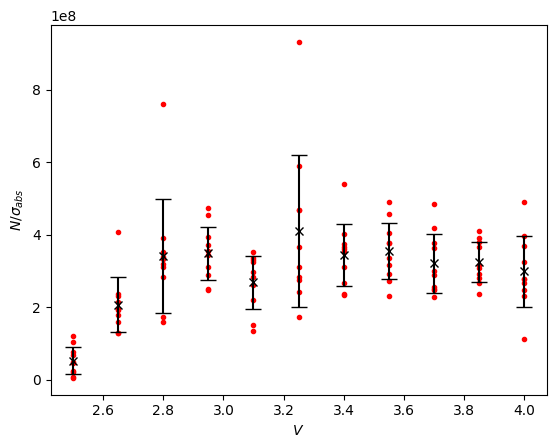

In [16]:
plt.errorbar(time_list,means, yerr = errs, c= "k", capsize = 6, linestyle = "None", marker = "x")
for key,val in sigma_times.items():
    plt.scatter([key]*len(val),val, marker = '.', c = 'r')
plt.ylabel(r"$N/\sigma_{abs}$")
plt.xlabel(r"$V$")